In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(2, .5, size=n)
phat0 = g*F0/S0 #derivative, integral and proportion
#agents as controllers, co-steering

#wakeup rates
gamma =  sts.expon.rvs(loc=1,scale=5, size=n)

#holdings fiat
h = sts.expon.rvs( loc=100,scale=1000, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

(array([43., 25., 15.,  9.,  2.,  5.,  0.,  0.,  0.,  1.]),
 array([ 1.01601195,  3.73402387,  6.45203579,  9.17004771, 11.88805963,
        14.60607155, 17.32408347, 20.04209539, 22.76010731, 25.47811923,
        28.19613115]),
 <a list of 10 Patch objects>)

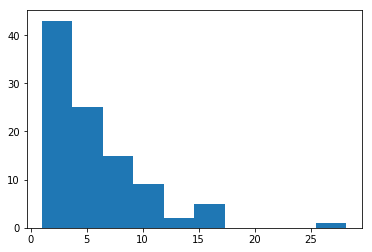

In [4]:
plt.hist(gamma)

In [5]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'rates':[1/gamma],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0],
    'dust' : [dust]}

In [6]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'actions': {}}

In [7]:
initial_conditions

{'holdings': array([1630.2298745 , 1855.95933223, 1021.08308112, 1021.17489624,
        1551.64766639, 3089.79103785, 1454.26793311,  311.24997462,
         723.56336505, 2035.55399169, 1922.79400139,  806.68969103,
        1033.59113411,  114.76886848, 2350.45235662,  190.05653552,
        2644.80637053, 1250.11752987, 1110.40804303, 2869.18844696,
        1780.78548947,  702.27399498,  121.70167749, 2402.46351979,
        5570.90146408,  276.66605014,  340.25231682,  481.62823936,
        1404.3312626 ,  770.72400366, 1029.67775184,  256.05635259,
        1532.14757902,  155.28659834, 1419.25038106,  409.29945326,
         729.75983398, 1727.74265818,  452.7726691 ,  738.63104154,
         701.63688848, 2493.85863965, 1173.49990866,  650.47252007,
         180.29150834,  523.99524538,  408.74079833,  751.69733115,
        1899.61093565,  774.24381268,  467.776586  , 1628.27714972,
        1757.45280537,  240.33368107, 2938.67347979,  271.11884768,
        2022.86606662,  342.55089686

In [8]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    #if delF <1:
    #    if s['funds'] <1000:
    #        delF =100
    
    return({'delF':delF})

In [9]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [10]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [11]:
#change in F (revenue and spending accounted for)
def choose_agents(params, step, sL, s):
    n = params['population']
    rates = params['rates']
    
    agents = []
    for a in range(n):
        sq_gap = (s['spot_price']-s['prices'][a])**2
        pr = (rates[a]+sq_gap)/(1+sq_gap) #rates when sq_gap =0, 1 when sq_gap -> infty
        rv = np.random.rand()
        if rv < pr:
            agents.append(a)
    
    #shuffle
    shuffled_agents =np.random.choice(agents,len(agents), False)     
        
    return({'agents':shuffled_agents})

In [12]:
def agent_actions(params, step, sL, s, _input):
    
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    P=s['spot_price']
    
    actions = []
    for a in _input['agents']:
        h_a = s['holdings'][a]
        phat_a = s['prices'][a]
        s_a =  s['tokens'][a]
        beta = params['beta']

        if P>phat_a: #equiv: pbar(0)>phat_a
            mech = 'burn'
                        
            #approx for burn s.t. p=phat
            #armijo style
            amt = s_a
            
            def pbar(amt):
                output = withdraw_with_tax(amt, R,S, V0, params['phi'], params['kappa'])

                if not(output[2])>0:
                    return np.Infinity
                else:
                    return output[2]

            if amt > 10**-8:
                while pbar(amt)< phat_a:
                    amt = amt*beta

        else: # P<phat_a; #equiv pbar(0)<phat_a
            mech = 'bond'
            #approx for buy s.t. p=phat
            #armijo style
            amt = h_a
  
            def pbar(amt):
                output = mint(amt, R,S, V0, params['kappa'])

                if not(output[1])>0:
                    return 0
                else:
                    return output[1]
                
            if amt > params['dust']:
                while pbar(amt)> phat_a:
                    amt = amt*beta
        
        action = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt),'posterior':{}}
        
        if action['mech'] == 'bond':
            h_a = h_a-amt
            dS, pbar = mint(amt, R,S, V0, params['kappa'])
            R = R+amt
            S = S+dS
            s_a = s_a+dS
            P = spot_price(R, V0, kappa)
    
        elif action['mech'] == 'burn':
            s_a = s_a-amt
            dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
            R = R-dR
            F = F + params['phi']*dR
            S = S-amt
            h_a = h_a + (1-params['phi'])*dR
            P = spot_price(R, V0, kappa)
        
        action['posterior'] = {'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a}
        actions.append(action)
        
    key = 'actions'
    value = actions
    
    return (key, value)

In [13]:
def resolve_actions(params, step, sL, s):
    
    H_a = s['holdings']
    S_a =  s['tokens']
    
    actions = s['actions']
    
    for action in actions:
        a= action['agent']
        H_a[a] = action['posterior']['h_a']
        S_a[a] = action['posterior']['s_a']
    
    #last action only
    F = action['posterior']['F']
    R = action['posterior']['R']
    P = action['posterior']['P']
    S = action['posterior']['S']
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'S_a':S_a, 'H_a':H_a})

In [14]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    H_a = _input['H_a']
    
    key = 'holdings'
    value = H_a
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    S_a = _input['S_a']
    
    sumS = np.sum(S_a)
    S = _input['S']
    
    tokens = S_a*S/sumS
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [15]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agents
        },
        'variables': { 
            'actions': agent_actions, 
        }
    },
    {
      'policies': {
          'act': resolve_actions,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [16]:
time_periods_per_run = 5000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [17]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 5000), 'M': {'kappa': 2, 'lambda': 200, 'gains': array([1.5159468 , 2.32777741, 2.07901857, 2.70193246, 1.23019405,
       2.187849  , 1.25467048, 2.56091955, 1.37446065, 1.83583304,
       1.9989768 , 1.72103745, 2.06099015, 1.62395615, 2.03885877,
       1.46226526, 1.88502293, 3.57304684, 0.57894065, 1.41376682,
       1.56914357, 3.07016942, 2.20847962, 2.56330296, 2.65474802,
       1.82931647, 1.59744544, 2.09100084, 1.98728554, 1.65800825,
       1.9636593 , 2.31740024, 1.98388073, 1.49079768, 1.37198294,
       1.63062335, 1.61305404, 1.78552002, 2.36553562, 1.40983834,
       2.69925114, 2.38155665, 2.60825401, 1.70096019, 2.62650413,
       1.64728369, 2.45007895, 3.10938498, 2.70574011, 1.47169328,
       2.45237318, 2.25393107, 2.06743862, 1.70220006, 2.82728328,
       1.98508886, 1.58720606, 0.89273127, 2.6903916 , 2.35334208,
       1.73698547, 0.92538001, 2.31508438, 1.56895116, 1.6570793 ,
       1.9786569 , 2.03045841, 2.54540533, 2.16934174, 3

In [18]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [19]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a1c4df828>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a1c4df828>]


/Users/Zargham/Documents/GitHub/conviction/bonding_curve_eq.py:62: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/Zargham/Documents/GitHub/conviction/bonding_curve_eq.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS


In [20]:
experiment_index = 0
df = results[experiment_index]['result']

In [21]:
df.head()

,actions,funds,holdings,prices,reserve,run,spot_price,substep,supply,timestep,tokens
0,{},50000.000000,"[1630.2298745009696, 1855.9593322341605, 1021....","[0.07579733997174615, 0.11638887034418618, 0.1...",50000.000000,1,0.100000,0,1.000000e+06,0,"[6097.1340695422605, 9273.717037965478, 8780.4..."
1,{},49864.871242,"[1630.2298745009696, 1855.9593322341605, 1021....","[0.07579733997174615, 0.11638887034418618, 0.1...",50000.000000,1,0.100000,1,1.000000e+06,1,"[6097.1340695422605, 9273.717037965478, 8780.4..."
2,"[{'agent': 87, 'mech': 'burn', 'amt': 11015.24...",49864.871242,"[1630.2298745009696, 1855.9593322341605, 1021....","[0.07579733997174615, 0.11638887034418618, 0.1...",50000.000000,1,0.100000,2,1.000000e+06,1,"[6097.1340695422605, 9273.717037965478, 8780.4..."
3,"[{'agent': 87, 'mech': 'burn', 'amt': 11015.24...",50534.026662,"[1630.2298745009696, 0.0, 1021.0830811246624, ...","[0.07579733997174615, 0.11638887034418618, 0.1...",53508.319894,1,0.103449,3,1.034488e+06,1,"[6097.134069542257, 27658.98786673803, 8780.48..."
4,"[{'agent': 87, 'mech': 'burn', 'amt': 11015.24...",50379.559676,"[1630.2298745009696, 0.0, 1021.0830811246624, ...","[0.0740529238197225, 0.11371027205274396, 0.10...",53508.319894,1,0.103449,1,1.034488e+06,2,"[6097.134069542257, 27658.98786673803, 8780.48..."


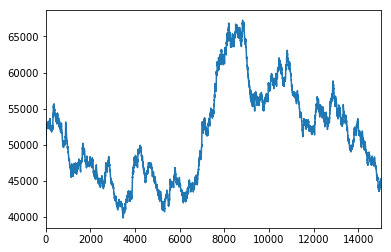

In [22]:
df.funds.plot()

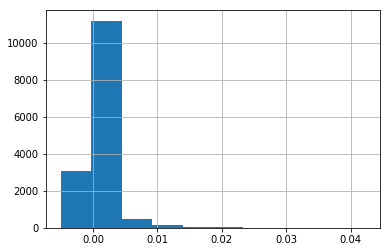

In [23]:
(df.funds.diff()/df.funds).hist()

In [24]:
rdf = df[df.substep == 3].copy()

In [25]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

In [26]:
rdf['holding_wts'] = (rdf.holdings/rdf.holdings.apply(sum))
rdf['h_wt_mean_price'] = (rdf.holding_wts*rdf.prices).apply(sum)

In [27]:
rdf['wealth'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [28]:
rdf['wealth_wts'] = rdf.wealth/rdf.wealth.apply(sum)
rdf['w_wt_mean_price'] = (rdf.wealth_wts*rdf.prices).apply(sum)

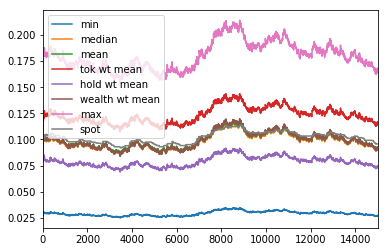

In [29]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

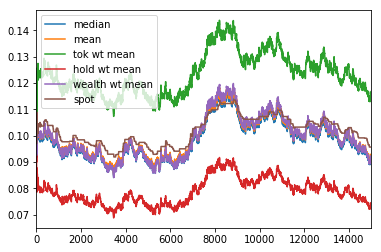

In [30]:
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.spot_price.plot()
plt.legend(['median','mean','tok wt mean','hold wt mean','wealth wt mean', 'spot'])

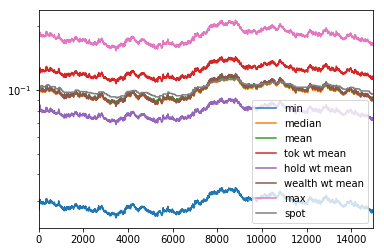

In [31]:
rdf.prices.apply(np.min).plot(logy=True)
rdf.prices.apply(np.median).plot(logy=True)
rdf.prices.apply(np.mean).plot(logy=True)
rdf.wt_mean_price.plot(logy=True)
rdf.h_wt_mean_price.plot(logy=True)
rdf.w_wt_mean_price.plot(logy=True)
rdf.prices.apply(np.max).plot(logy=True)
rdf.spot_price.plot(logy=True)
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [32]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

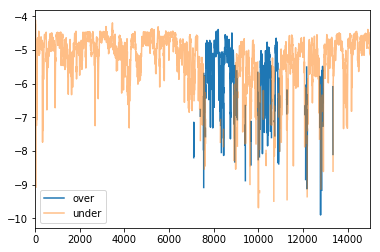

In [33]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [34]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

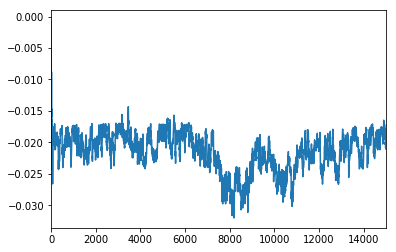

In [35]:
rdf.est_err.plot()

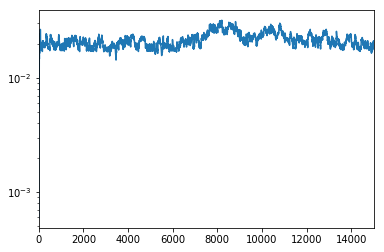

In [36]:
rdf.est_err.apply(np.abs).plot(logy=True)

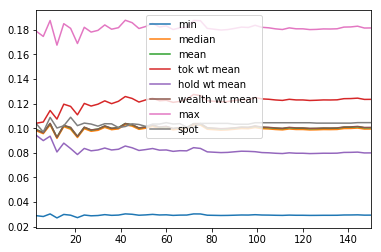

In [37]:
#head T
T = 50
rdf.head(T).prices.apply(np.min).plot()
rdf.head(T).prices.apply(np.median).plot()
rdf.head(T).prices.apply(np.mean).plot()
rdf.head(T).wt_mean_price.plot()
rdf.head(T).h_wt_mean_price.plot()
rdf.head(T).w_wt_mean_price.plot()
rdf.head(T).prices.apply(np.max).plot()
rdf.head(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

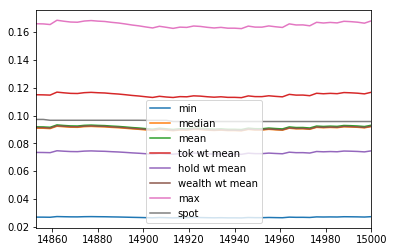

In [38]:
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).h_wt_mean_price.plot()
rdf.tail(T).w_wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [39]:
tx_data = rdf.actions.values
transactions = []
states = []
for t in range(time_periods_per_run):
    for tx in range(len(tx_data[t])):
        states.append(tx_data[t][tx]['posterior'])
        transactions.append(tx_data[t][tx])


In [40]:
sdf = pd.DataFrame(states)
tdf = pd.DataFrame(transactions).drop('posterior', axis=1)

In [41]:
ind=tdf[tdf.amt==0].index
tdf.drop(ind, inplace=True)
sdf.drop(ind, inplace=True)

In [42]:
txdf = sdf.merge(tdf, right_index=True, left_index=True)

In [43]:
txdf.head()

,F,P,R,S,a,h_a,s_a,agent,amt,mech,pbar
0,49919.644129,0.098898,48904.542247,988984.754656,87,1977.998978,0.0000,87,11015.245344,burn,0.094477
1,49984.599978,0.097576,47605.425266,975760.475382,60,2508.871593,0.0000,60,13224.279275,burn,0.093325
2,50038.969903,0.096455,46518.026767,964551.986853,26,1373.280891,0.0000,26,11208.488528,burn,0.092165
3,50038.969903,0.097180,47219.663656,971798.988018,40,0.000000,38807.7801,40,701.636888,bond,0.096818
4,50084.863780,0.096231,46301.786112,962307.498799,49,1646.227479,0.0000,49,9491.489219,burn,0.091870


In [44]:
emas = ['P', 'pbar']
for com in [2,4,8,16]:
    k = 'pbar_ewma'+str(com)
    emas.append(k)
    txdf[k] = txdf.pbar.ewm(com).mean()

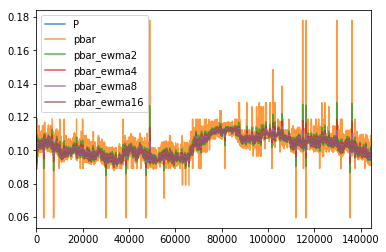

In [45]:
txdf[emas].plot(alpha=.8)

[0, 3000, 0.095, 0.115]

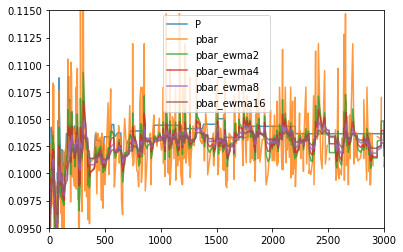

In [46]:
txdf[emas].plot(alpha=.8)
plt.axis([0, 3000, .095, .115])

In [47]:
txdf['dP'] = txdf.P.diff()
txdf['percent_dP'] = txdf.P.pct_change().apply(abs)

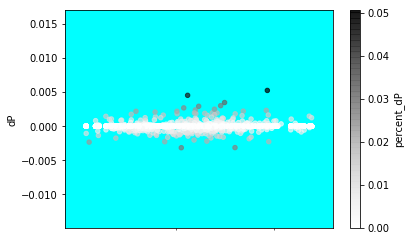

In [48]:
txdf.plot.scatter(x='R', y='dP', c='percent_dP', alpha=.7, logx=True)
plt.gca().set_facecolor('cyan') 

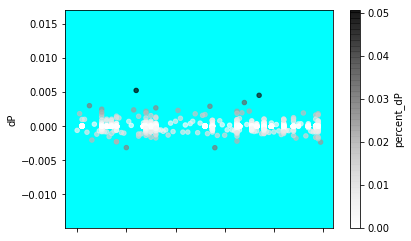

In [49]:
txdf.plot.scatter(x='a',y='dP', c='percent_dP', alpha=.7)
plt.gca().set_facecolor('cyan') 

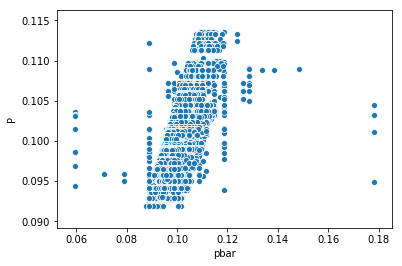

In [50]:
sns.scatterplot(x="pbar", y="P", data=txdf) 

In [51]:
#txdf.plot(x='pbar',y='P')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


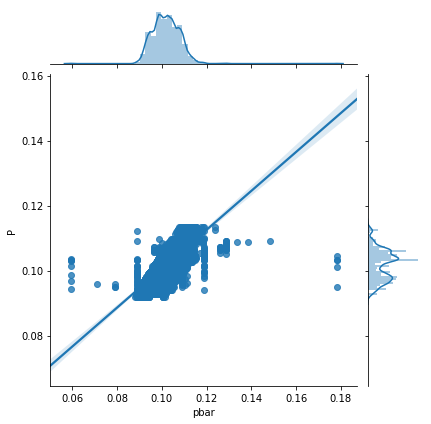

In [52]:
sns.jointplot(x="pbar", y="P",kind="reg", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all")) 

In [53]:
txdf['P_err'] = txdf.P-txdf.pbar

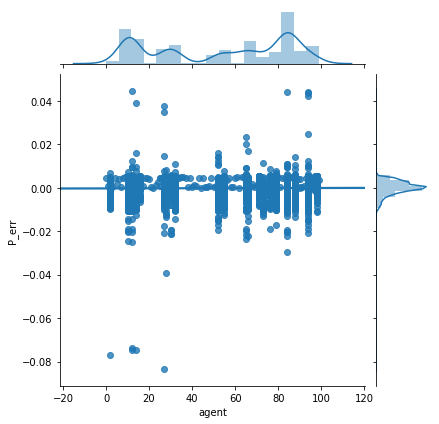

In [54]:
sns.jointplot(x="agent", y="P_err",kind="reg", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all")) 

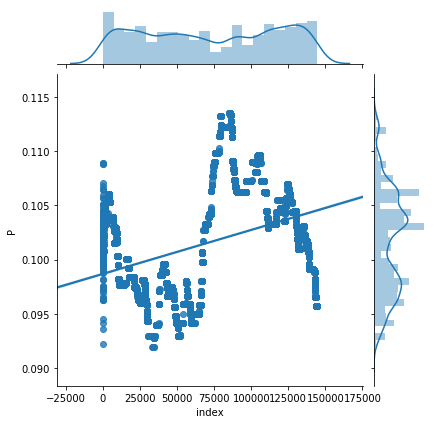

In [55]:
sns.jointplot(x='index',y="P",kind="reg", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all").reset_index()) 

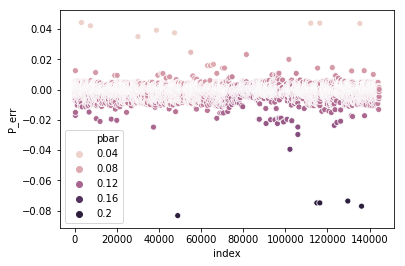

In [56]:
sns.scatterplot(x='index',y="P_err", hue = "pbar", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all").reset_index()) 

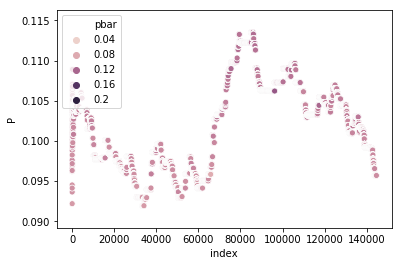

In [57]:
sns.scatterplot(x='index',y="P", hue = "pbar", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all").reset_index()) 

In [58]:
txdf['P_err_factor'] = txdf.P/txdf.pbar

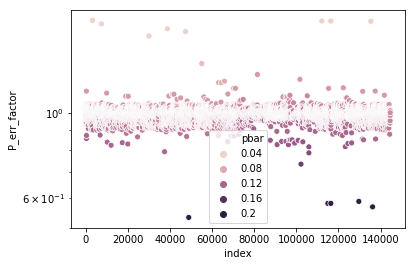

In [59]:
sns.scatterplot(x='index',y="P_err_factor", hue = "pbar", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all").reset_index()) 
plt.gca().set_yscale('log')

In [60]:
tx_summary=tdf[['agent','mech','pbar','amt']].groupby(['agent','mech']).agg(['median','count']).T.iloc[:-1].T

In [61]:
tx_summary

pbar                   amt
              median   count        median
agent mech                                
0     burn  0.094794     1.0  6.097134e+03
1     bond  0.100948     1.0  1.855959e+03
2     bond  0.098958    39.0  1.728040e-10
      burn  0.097686   111.0  1.002776e-09
3     bond  0.101408     1.0  1.021175e+03
4     burn  0.095561     1.0  8.808591e+03
5     bond  0.102747     1.0  3.089791e+03
6     burn  0.097568     1.0  2.029219e+04
7     bond  0.103367     1.0  3.112500e+02
8     burn  0.095867     1.0  1.166624e+04
9     burn  0.098393     1.0  6.811953e+03
10    bond  0.103256    79.0  7.603376e-10
      burn  0.101466  1809.0  1.111844e-09
11    burn  0.092871     1.0  8.011316e+03
12    bond  0.098958   127.0  2.142770e-10
      burn  0.101609   871.0  5.422875e-10
13    burn  0.099670     1.0  1.521244e+04
14    bond  0.098958    47.0  3.663445e-10
      burn  0.100152   227.0  7.670403e-10
15    burn  0.097542     1.0  6.900543e+03
16    bond  0.111903     6.0  4.231066e+02
      burn  0.110528    95.0  3.610717e-09
17    bond  0.103833     1.0  1.250118e+03
18    burn  0.095300     1.0  9.263889e+03
19    burn  0.095945     1.0  1.009392e+04
20    burn  0.101867     1.0  3.136327e+04
21    bond  0.100499     1.0  7.022740e+02
22    bond  0.102512     1.0  1.217017e+02
23    bond  0.100621     1.0  2.402464e+03
24    bond  0.106281     1.0  5.570901e+03
...              ...     ...           ...
77    burn  0.096790     1.0  7.763394e+03
78    burn  0.096292     1.0  9.112173e+03
79    bond  0.098958    51.0  1.382432e-10
      burn  0.097348   152.0  9.443635e-10
80    burn  0.097266     1.0  8.436311e+03
81    bond  0.097481     1.0  2.388221e+02
82    burn  0.091780     1.0  6.938506e+03
83    burn  0.095375     1.0  1.223904e+04
84    bond  0.103309   111.0  6.566552e-10
      burn  0.100193  2712.0  1.122235e-09
85    burn  0.099351     1.0  6.210150e+03
86    burn  0.095750     1.0  6.562628e+03
87    burn  0.094477     1.0  1.101525e+04
88    bond  0.100937    64.0  6.462869e-10
      burn  0.099763   636.0  1.083188e-09
89    burn  0.090623     1.0  1.742318e+04
90    bond  0.102381     2.0  1.728556e+02
      burn  0.104705     1.0  1.300510e-08
91    bond  0.100668     1.0  3.587790e+02
92    bond  0.102932     1.0  1.993844e+03
93    burn  0.095702     1.0  1.420652e+04
94    bond  0.098958   116.0  2.039087e-10
      burn  0.100332   661.0  5.670183e-10
95    burn  0.098004     1.0  7.108961e+03
96    burn  0.096492     1.0  8.316739e+03
97    bond  0.104414     2.0  1.377940e+03
      burn  0.109584    26.0  2.586773e-09
98    bond  0.109203    15.0  5.495167e-09
      burn  0.109515   142.0  1.903134e-09
99    burn  0.088688     1.0  2.331425e+04

[124 rows x 3 columns]

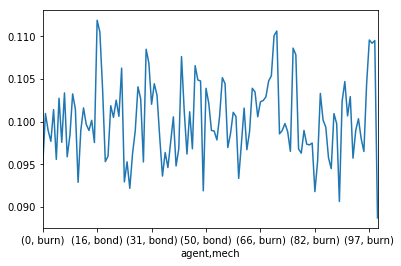

In [62]:
tx_summary.pbar['median'].plot()

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


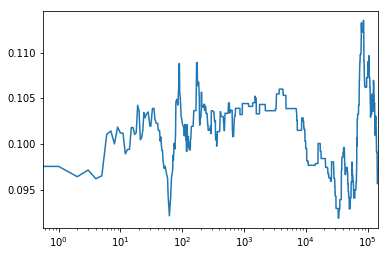

In [63]:
sdf['P'].plot(logx=True)

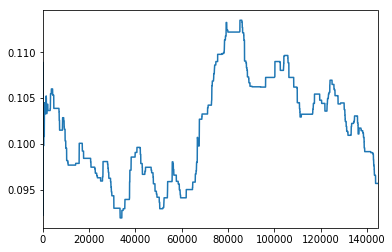

In [64]:
sdf['P'].plot()

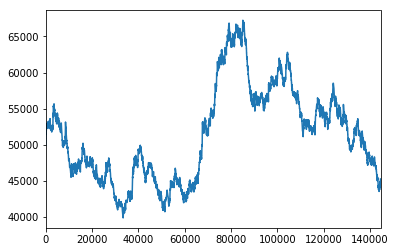

In [65]:
sdf.F.plot()

In [66]:
bond_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='bond']
burn_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='burn']

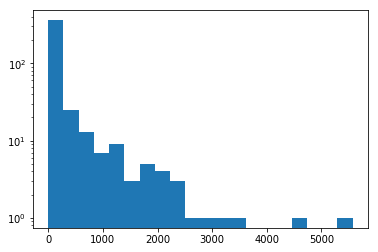

In [67]:
plt.hist(bond_amts, bins=20)
plt.yscale('log')

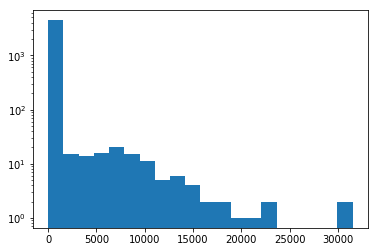

In [68]:
plt.hist(burn_amts, bins=20)
plt.yscale('log')

In [69]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

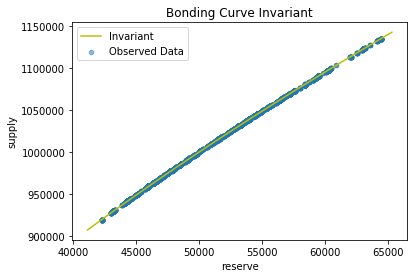

In [70]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

In [71]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

(array([46., 16., 18.,  6.,  5.,  3.,  3.,  2.,  0.,  1.]),
 array([   0.        ,  713.23060194, 1426.46120389, 2139.69180583,
        2852.92240778, 3566.15300972, 4279.38361167, 4992.61421361,
        5705.84481555, 6419.0754175 , 7132.30601944]),
 <a list of 10 Patch objects>)

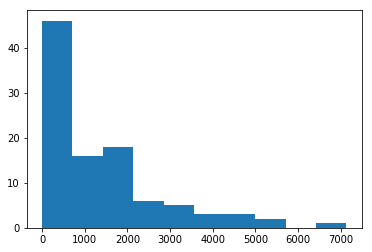

In [72]:
plt.hist(rdf.iloc[-1].holdings)

In [73]:
rdf['gini_h'] = rdf.holdings.apply(gini)

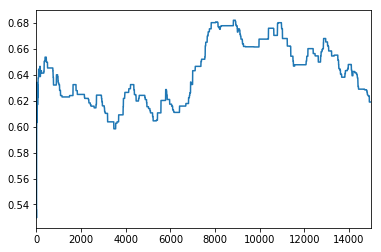

In [74]:
rdf.gini_h.plot()

(array([56.,  8., 13.,  6.,  6.,  4.,  4.,  1.,  0.,  2.]),
 array([    0.        ,  5810.80401075, 11621.60802149, 17432.41203224,
        23243.21604299, 29054.02005373, 34864.82406448, 40675.62807523,
        46486.43208597, 52297.23609672, 58108.04010746]),
 <a list of 10 Patch objects>)

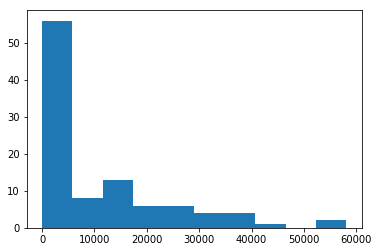

In [75]:
plt.hist(rdf.iloc[-1].tokens)

In [76]:
rdf['gini_s'] = rdf.tokens.apply(gini)

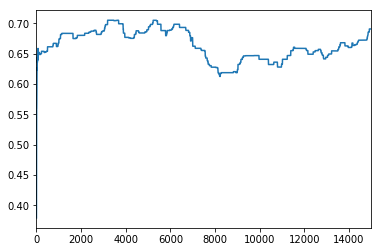

In [77]:
rdf.gini_s.plot()

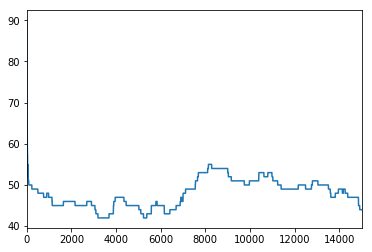

In [78]:
rdf.tokens.apply(np.count_nonzero).plot()

In [79]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

(array([26., 32., 13.,  9., 10.,  2.,  4.,  3.,  0.,  1.]),
 array([ 648.24831903, 1296.65408907, 1945.05985911, 2593.46562915,
        3241.8713992 , 3890.27716924, 4538.68293928, 5187.08870932,
        5835.49447936, 6483.9002494 , 7132.30601944]),
 <a list of 10 Patch objects>)

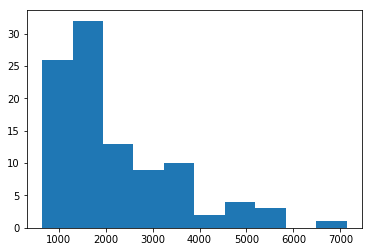

In [80]:
plt.hist(rdf.iloc[-1].asset_value)

In [81]:
rdf['gini'] = rdf.asset_value.apply(gini)

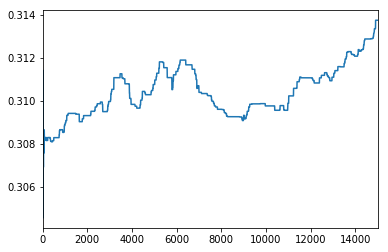

In [82]:
rdf.gini.plot()

In [83]:
rdf['pref_gap'] = (rdf.prices - rdf.spot_price)/rdf.spot_price

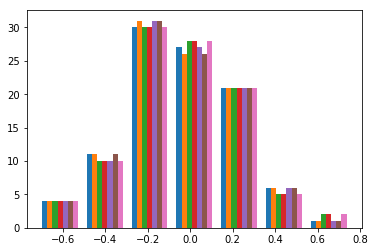

In [84]:
plt.hist(rdf.iloc[-7:].pref_gap, bins=7)
plt.show()